# 0. DT복습

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV

import graphviz
from sklearn.tree import export_graphviz

In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
iris = pd.read_csv("../data/Iris.csv",
                   index_col = 0)

1. iris 데이터 중 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm' feature로 하는 x_train, x_test, y_train, y_test를 만드시오. (이때, test_size=0.20, random_state = 209로 한다.)

In [6]:
x_data = iris[iris.columns[1:-1]]
y_data = iris["Species"]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.2,
                                                    random_state = 209)

2. y_test를 분류하는 Decision Tree 모델을 만드시오.(이때, max_depth = 2, random_state=209로 한다.)

* [Decision Tree 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

* criterion: 불순도를 계산할 함수
    * gini, entropy
    * 두 함수가 비슷한 결과를 냄
* splitter: 노드를 분할하는 방법
    * best: 정보의 이득이 최대가 될 때
    * random: 랜덤하게. best 보다 random이 더 효과적일 때도 있음
* max_depth: 몇 층까지 가지를 칠 것인지
    * 설정하지 않으면 불순도가 0이되거나 min_samples_split보다 샘플수가 적을 때까지 가지를 침  
    * max_depth = 1로 준 DT를 스텀프라고 부름. 부스터로 사용하면 강력해 질 수 있음
* min_samples_split: 노드를 나누기 위한 최소 샘플 수
    * 최소 2개는 샘플이 있어야 가지를 치기 때문에 default는 2이다.
* min_samples_leaf: leaf의 최소 샘플 수
    * leaf노드는 최소 1개의 샘플을 가지고 있어야 함. 
    * 만약  min_samples_leaf를 4로 준다면 모든 리프 노드가 최소 4개의 샘플을 가지고 있게 된다.
* max_features: 특성의 개수
    * input의 특성에서 max_features만큼 랜덤하게 추출
* random_state: max_features만큼 특성을 랜덤하게 선택하기 때문에 필요
* max_leaf_nodes: 리프 노드의 전체 샘플 개수
* min_impurity_decrease: 가지를 치기 위한 최소 불순도 감소

**일반적으로 max 이름을 가진 하이퍼파라미터는 감소하고, min 이름을 가진 하이퍼파라미터는 증가 시키면 모델의 성능이 향상됨**

In [8]:
model = DecisionTreeClassifier(max_depth = 2, random_state=209) 
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=209)

In [9]:
prediction = model.predict(x_test)
print('The accuracy of the DT is', 
      metrics.accuracy_score(prediction, y_test))

The accuracy of the DT is 0.9666666666666667


3. 모델의 feature importance를 직접 계산하시오

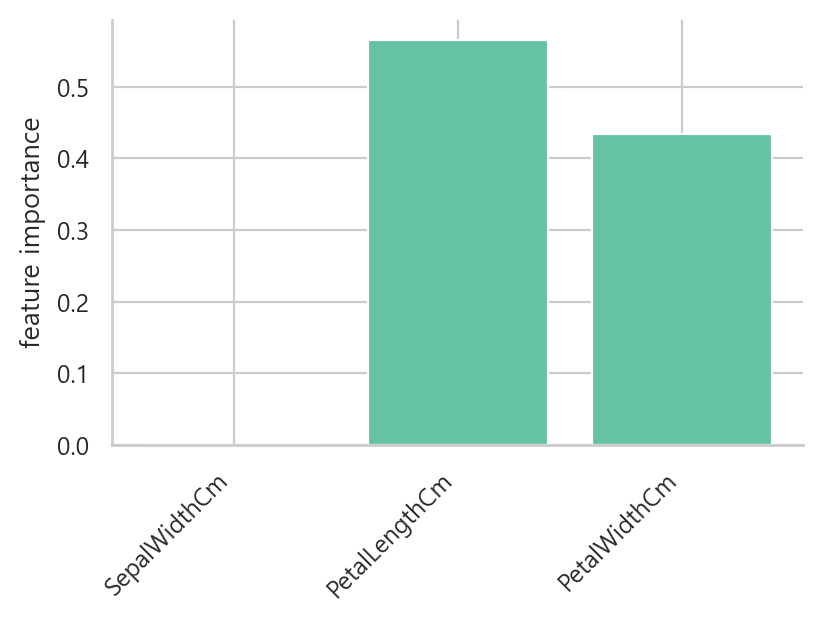

In [10]:
fig, ax = plt.subplots(figsize=(4,3))

ax.bar(iris.columns[1:-1], model.feature_importances_)
ax.spines[["top", "right"]].set_visible(False)
ax.set(ylabel = "feature importance")

plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

In [11]:
model.feature_importances_

array([0.        , 0.56535966, 0.43464034])

In [ ]:
img = export_graphviz(model, out_file='../data/decision_tree_hw.dot')
with open("../data/decision_tree_hw.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

어떤 특성 $f_i$에 대한 중요도 $I(f_i)$는 다음과 같이 얻을 수 있다:
\begin{equation}
I(f_i) = \sum_{\substack{p\in f_i\text{에 의해} \\ \text{가지치기한 부모 노드}}}\frac{N_p}{N}\left(G(D_p) - \frac{N_{l}}{N_p}G(D_l) - \frac{N_{r}}{N_p}G(D_r)\right)
\end{equation}

이것을 정규화하게 되면 
\begin{equation}
I(f_i)_{\text{normalize}} = \frac{I(f_i)}{\sum_{j\in\text{all features}}I(f_j)}
\end{equation}
이 된다. 

따라서, 

\begin{align}
I(f_{1}) = \frac{120}{120}\left(0.667 - \frac{40}{120}\cdot 0 - \frac{80}{120}\cdot 0.5\right)
\doteqdot 0.333
\end{align}

\begin{align}
I(f_2) &= \frac{80}{120}\left(0.5 - \frac{44}{80}\cdot 0.165 - \frac{36}{80}\cdot 0.054\right)
\doteqdot 0.256,
\end{align}

이고, 이것을 정규화하면
\begin{align}
I(f_{1})_{\text{normalize}} &= \frac{I(f_{2})}{I(f_2)+I(f_{3})} \doteqdot 0.565\\
I(f_{2})_{\text{normalize}} &= \frac{I(f_3)}{I(f_2)+I(f_{3})} \doteqdot 0.434.
\end{align}

# 1. 교차검증(cross validation)

* 검증 데이터: 훈련데이터에서 모델을 검증하기 위해 떼어 놓는 데이터
    * 실전에서 테스트는 모델을 성능 평가에 사용할 수 없기 때문에
* 교차 검증: 데이터가 적을 때 모델을 그나마(?) 안정적으로 평가할 수 있는 방법
    * 훈련 데이터로 모델을 학습 시키고
    * 검증 데이터로 모델을 평가
    * 모델의 최종 평가는 검증 데이터의 평균으로!

| | | |
|---|---|---|
|훈련 데이터|훈련 데이터|**검증 데이터**|
|훈련 데이터|**검증 데이터**|훈련 데이터|
|**검증 데이터**|훈련 데이터|훈련 데이터|

* $k$-fold cross validation: 훈련 데이터를 $k$등분 하여 교차 검증하는 방법
    * $k$가 5(20%) 혹은 10(10%)일때를 많이 사용
    
**주의! `cross_validate()`는 훈련 데이터를 섞어주지는 않는다!**

**따라서 분류 모델을 만들 때는 `cv=StratifiedKFold()`를 지정해 주는 것이 좋다.**

In [21]:
x_data = iris[iris.columns[1:-1]]
y_data = iris["Species"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.20,
                                                    random_state = 209)

In [24]:
x_train

,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,,,
49,3.7,1.5,0.2
53,3.1,4.9,1.5
83,2.7,3.9,1.2
141,3.1,5.6,2.4
27,3.4,1.6,0.4
...,...,...,...
32,3.4,1.5,0.4
40,3.4,1.5,0.2
59,2.9,4.6,1.3


In [26]:
model = DecisionTreeClassifier(max_depth = 2, random_state=209) 

In [28]:
# test_score를 혼동하지 마세요!
score = cross_validate(estimator = model, 
                       X = x_train, 
                       y = y_train, 
                       cv = 5)
score

{'fit_time': array([0.00426054, 0.00436234, 0.00597978, 0.00398016, 0.00357103]),
 'score_time': array([0.00202394, 0.00301814, 0.00452685, 0.00149965, 0.00199413]),
 'test_score': array([0.95833333, 0.91666667, 1.        , 0.91666667, 0.91666667])}

In [17]:
# 5-fold cross validation의 결과
np.mean(score["test_score"])
#cross_val_score(model, x_train, y_train, cv = 5)

0.9416666666666667

In [19]:
# 주의! `cross_validate()`는 훈련 데이터를 섞어주지는 않는다!
# 따라서 분류 모델을 만들 때는 `cv=StratifiedKFold()`를 지정해 주는 것이 좋다.

score_strat = cross_validate(estimator = model, 
                             X = x_train, 
                             y = y_train, 
                             cv = StratifiedKFold())
np.mean(score_strat["test_score"])
score_strat

{'fit_time': array([0.00349832, 0.00306678, 0.00415587, 0.00399399, 0.00293064]),
 'score_time': array([0.00299144, 0.00365996, 0.00349855, 0.00199342, 0.00299406]),
 'test_score': array([0.95833333, 0.91666667, 1.        , 0.91666667, 0.91666667])}

In [30]:
splitter = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 42)

score_strat_split = cross_validate(estimator = model, 
                             X = x_train, 
                             y = y_train, 
                             cv = splitter)

score_strat_split

{'fit_time': array([0.00559974, 0.00594163, 0.00199294, 0.00299788, 0.00366926,
        0.00298667, 0.00399113, 0.00702333, 0.00203061, 0.00542068]),
 'score_time': array([0.00253391, 0.00206637, 0.0024972 , 0.00199676, 0.00206041,
        0.00375628, 0.0023284 , 0.00205469, 0.00234199, 0.00099635]),
 'test_score': array([1.        , 0.91666667, 0.66666667, 0.83333333, 1.        ,
        1.        , 0.91666667, 0.83333333, 1.        , 1.        ])}

# 2. 그리드 서치(Grid Search)

* 모델 파라미터(일반적으로 말하는 파라미터를 의미): 모델이 학습 하면서 변화하게 되는 값. 딥러닝 모델의 경우 가중치가 파라미터

* 하이퍼 파라미터(매개변수): 모델의 학습 전에 설정해 주는 값. 아무런 설정도 하지 않으면 기본값(`default`)로 학습하게 됨

In [31]:
# max_depth = 3
model = DecisionTreeClassifier(max_depth = 3, random_state=209) 
model.fit(x_train.values, y_train.values)
prediction = model.predict(x_test.values)
print('The accuracy of the DT is', 
      metrics.accuracy_score(prediction, y_test))

The accuracy of the DT is 0.9333333333333333


* GridSearchCV는 k-fold cross validation도 해준다!
* 아래의 코드의 경우 params의 변수가 4개이고, cv가 3이므로 params의 변수 하나 마다 3번의 결과를 내놓는다. 즉, 12번의 학습을 하게 된다. 
* 따라서 그리드서치를 할 때에는 `n_jobs = -1`(모든 코어 사용)로 하는 것이 좋다.

In [33]:
params = {"max_depth" : [3, 4, 5, 10]}

model_base = DecisionTreeClassifier(random_state=209) 
model_grid = GridSearchCV(model_base, 
                          params, 
                          cv=3, 
                          return_train_score=True,
                          #n_jobs = -1
                         )
model_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=209),
             param_grid={'max_depth': [3, 4, 5, 10]}, return_train_score=True)

In [36]:
# 가장 결과가 좋은 매개변수(하이퍼 파라미터)
model_grid.best_params_

{'max_depth': 4}

In [37]:
# 훈련데이터 중 가장 좋은 정확도
model_grid.best_score_

0.9666666666666667

In [38]:
# 가장 결과가 좋은 매개변수로 테스트 데이터를 예측해 보자
model_best = model_grid.best_estimator_
model_best.predict(x_test)

array(['Iris-versicolor', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor'],
      dtype=object)

In [40]:
## model_best의 테스트 데이터에 대한 정확도를 계산하시오.
pred_best = model_best.predict(x_test)
metrics.accuracy_score(pred_best, y_test)

0.9333333333333333

In [41]:
def grid_search(params, model_base=DecisionTreeClassifier(random_state=209)):
    model_grid = GridSearchCV(model_base, 
                              params, 
                              cv=3, 
                              return_train_score=True,
                              #n_jobs = -1
                             )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', metrics.accuracy_score(pred_best, y_test))

In [42]:
grid_search(params = {"min_samples_leaf": [1,2,4,8],
                     "max_depth" : [3, 4, 5, 10],
                      "criterion": ["gini", "entropy"]})

최상의 매개변수:  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}
훈련 데이터의 최고 정확도:  0.9666666666666667
테스트 데이터의 최고 정확도:  0.9333333333333333


**Quiz.** 지금 조건에서 GridSearchCV는 몇 번 실험을 할까?

**주의! min_samples_leaf에서 제일 좋은 결과를 내는 하이퍼 파라미터를 찾고, 그 다음으로 max_depth에서 제일 좋은 결과를 내는 하이퍼 파라미터를 찾는 것이 아니다!**

# 3. RandomizedSearchCV

* GridSearchCV로 하이퍼 파라미터를 튜닝하면 모든 조합에 대해서 테스트 하기 때문에 시간이 너무 오래걸린다는 단점이 있다. 
* 이를 보완하기 위해 RandomizedSearchCV를 사용할 수 있다. 
* RandomizedSearchCV의 작동방식은 GridSearchCV와 같지만 하이퍼 파라미터를 랜덤하게 조합하여 테스트 한다. 따라서 지정한 조합의 횟수 안에서 최상이 조합을 찾는다

* 실수 난수 생성: [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)

* 정수 난수 생성: [np.ramdom.randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

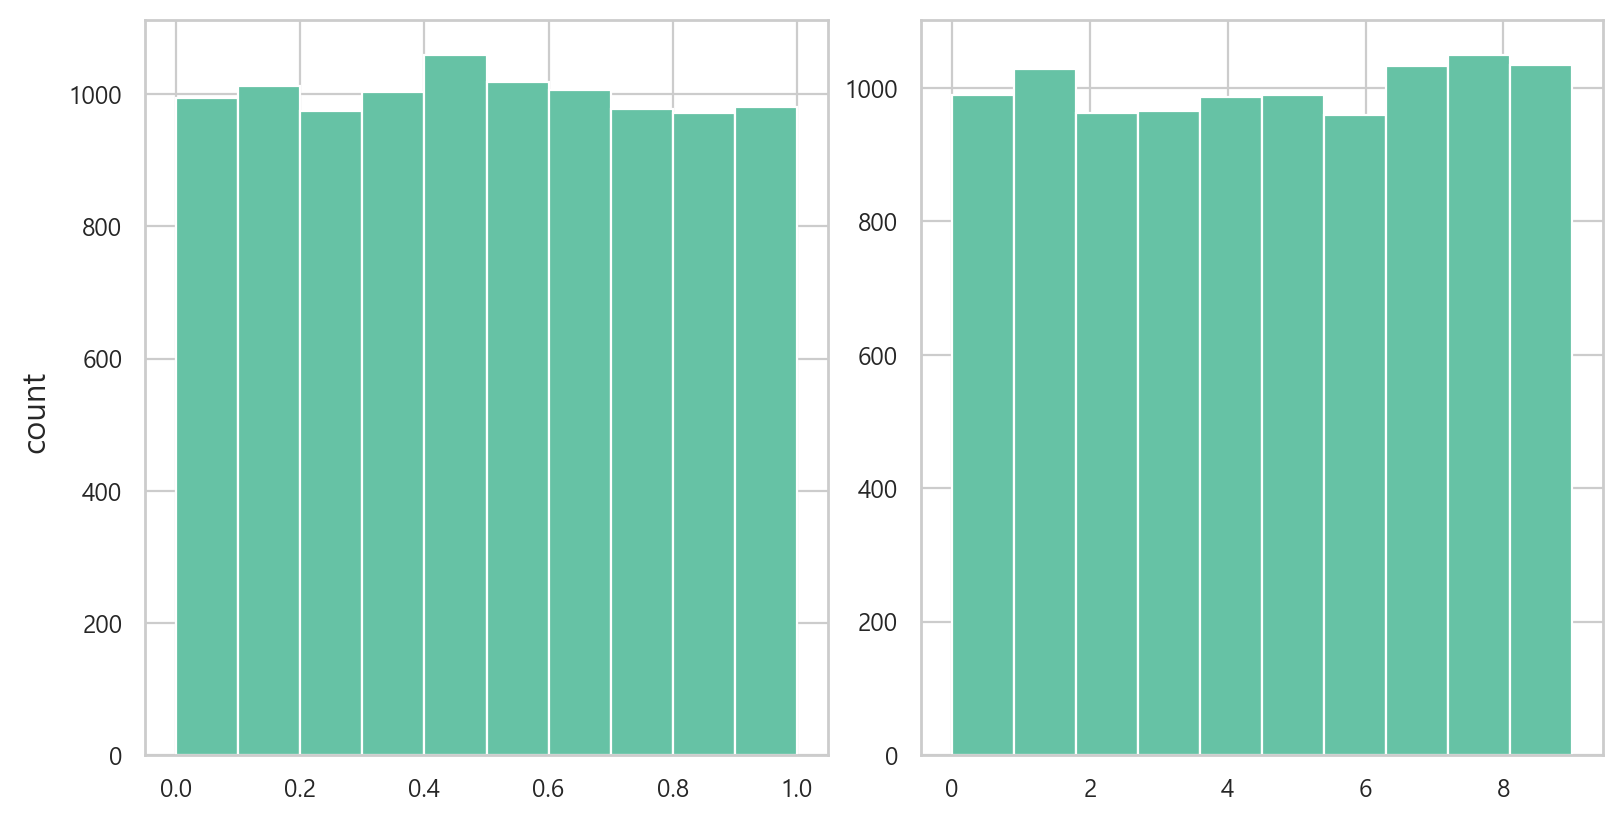

In [44]:
fig, (ax_uni, ax_int) = plt.subplots(1, 2, figsize = (8,4))

size = 10_000
bins = 10

ax_uni.hist(np.random.uniform(0, 1, size), bins = bins)
ax_int.hist(np.random.randint(0, 10, size), bins = bins)
fig.supylabel("count");

In [45]:
def random_grid_search(params, iters, model_base=DecisionTreeClassifier(random_state=209)):
    model_grid = RandomizedSearchCV(model_base, 
                                    params,
                                    n_iter = iters,
                                    cv=3, 
                                    return_train_score=True,
                                    #n_jobs = -1,
                                    random_state = 97
                                    )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', metrics.accuracy_score(pred_best, y_test))

In [47]:
params = {"criterion": ["entropy", "gini"],
          "min_samples_leaf": np.random.randint(1, 10, 10),
          "max_depth" : np.random.randint(3, 8, 20),
          "min_impurity_decrease": np.random.uniform(0.001, 0.01, 30)}

In [48]:
random_grid_search(params, 50, model_base)

최상의 매개변수:  {'min_samples_leaf': 5, 'min_impurity_decrease': 0.0029100571261848895, 'max_depth': 7, 'criterion': 'gini'}
훈련 데이터의 최고 정확도:  0.9500000000000001
테스트 데이터의 최고 정확도:  0.9666666666666667
